In [1]:
import os
import numpy as np
import unicodedata

# Ruta base
ruta_base = '/Users/Leon/Documents/Data GH/Aprendizaje automático /T4/data_tarea/train'
ruta_base = unicodedata.normalize('NFC', ruta_base)

train = []

# Recorrer cada subcarpeta (clase)
for clase in os.listdir(ruta_base):
    ruta_clase = os.path.join(ruta_base, clase)
    
    if os.path.isdir(ruta_clase):
        ruta_features = os.path.join(ruta_clase, 'features')
        
        if os.path.isdir(ruta_features):
            descriptores_clase = []
            
            for archivo in os.listdir(ruta_features):
                if archivo.endswith('.npy'):
                    ruta_archivo = os.path.join(ruta_features, archivo)
                    try:
                        datos = np.load(ruta_archivo)
                        if datos.shape[1] == 128:
                            descriptores_clase.append(datos)
                    except Exception as e:
                        print(f"Error cargando {ruta_archivo}: {e}")
            
            train.append(descriptores_clase)

# Verificar estructura
print(f"Total de clases: {len(train)}")
for i, clase in enumerate(train):
    print(f"Clase {i}: {len(clase)} imágenes. Primer descriptor tiene forma: {clase[0].shape if clase else 'vacía'}")



Total de clases: 15
Clase 0: 100 imágenes. Primer descriptor tiene forma: (1000, 128)
Clase 1: 100 imágenes. Primer descriptor tiene forma: (845, 128)
Clase 2: 100 imágenes. Primer descriptor tiene forma: (896, 128)
Clase 3: 100 imágenes. Primer descriptor tiene forma: (701, 128)
Clase 4: 100 imágenes. Primer descriptor tiene forma: (871, 128)
Clase 5: 100 imágenes. Primer descriptor tiene forma: (1001, 128)
Clase 6: 100 imágenes. Primer descriptor tiene forma: (1000, 128)
Clase 7: 100 imágenes. Primer descriptor tiene forma: (636, 128)
Clase 8: 100 imágenes. Primer descriptor tiene forma: (751, 128)
Clase 9: 100 imágenes. Primer descriptor tiene forma: (756, 128)
Clase 10: 100 imágenes. Primer descriptor tiene forma: (1000, 128)
Clase 11: 100 imágenes. Primer descriptor tiene forma: (493, 128)
Clase 12: 100 imágenes. Primer descriptor tiene forma: (581, 128)
Clase 13: 100 imágenes. Primer descriptor tiene forma: (1000, 128)
Clase 14: 100 imágenes. Primer descriptor tiene forma: (1000,

In [2]:
min_desc = float('inf')

for clase in train:
    for imagen in clase:
        if imagen.shape[0] < min_desc:
            min_desc = imagen.shape[0]

print(f"Número máximo de descriptores por imagen: {min_desc}")


Número máximo de descriptores por imagen: 127


In [3]:
# Calcular un centroide por clase basado en 60 muestras aleatorias de min_desc descriptores por imagen

n_replicas = 60
centroides_por_grupo_refinados = []

for clase in train[:15]:
    centroides = []

    for _ in range(n_replicas):
        descriptores_muestra = []

        for imagen in clase:
            indices = np.random.choice(imagen.shape[0], min_desc, replace=False)
            seleccion = imagen[indices]
            descriptores_muestra.append(seleccion)

        # Juntar y calcular centroide para esta réplica
        muestra_total = np.vstack(descriptores_muestra)
        centroide_muestra = muestra_total.mean(axis=0)
        centroides.append(centroide_muestra)

    # Promedio de los 60 centroides
    centroide_final = np.vstack(centroides).mean(axis=0)
    centroides_por_grupo_refinados.append(centroide_final)

# Mostrar el tamaño de un centroide refinado
centroides_por_grupo_refinados[0].shape


(128,)

In [4]:
# Ahora seleccionar los descriptores más cercanos al centroide por imagen
train_proximos_al_centroide = []

for clase_idx, clase in enumerate(train[:15]):
    clase_filtrada = []
    centroide = centroides_por_grupo_refinados[clase_idx]  # vector (128,)
    
    for imagen in clase:
        distancias = np.linalg.norm(imagen - centroide, axis=1)
        indices = np.argsort(distancias)[:min_desc]
        seleccionados = imagen[indices]
        clase_filtrada.append(seleccionados)

    train_proximos_al_centroide.append(clase_filtrada)


In [5]:
# Calcular en promedio cuántos ceros hay en los vectores de descriptores

# Asumimos que estamos trabajando con train_proximos_al_centroide, por ejemplo
# Concatenar todos los descriptores
todos_descriptores = np.vstack([imagen for clase in train_proximos_al_centroide for imagen in clase])

# Contar ceros por fila (descriptor)
ceros_por_descriptor = np.sum(todos_descriptores == 0, axis=1)

# Calcular el promedio de ceros por descriptor
promedio_ceros = ceros_por_descriptor.mean()
promedio_ceros


10.44844094488189

In [6]:
train_recortado=train_proximos_al_centroide

In [7]:
from sklearn.decomposition import PCA
import numpy as np

# Suponiendo que ya tienes cargado `train_recortado` con forma [15][100][128, 128]
# Paso 1: concatenar todos los descriptores
descriptores_totales = np.vstack([imagen for clase in train_recortado for imagen in clase])

# Paso 2: entrenar PCA
pca = PCA(n_components=118, random_state=42)
pca.fit(descriptores_totales)

# Paso 3: aplicar PCA a cada imagen
train_recortado_117d = [
    [pca.transform(imagen) for imagen in clase]
    for clase in train_recortado
]

# Verificar forma de una imagen reducida
print(train_recortado_117d[0][0].shape)  # → (128, 117)


(127, 118)


In [8]:
from sklearn.cluster import KMeans
import numpy as np

# Unir todos los descriptores (de forma [n_total, 128])
descriptores_individuales = []

for clase in train_recortado_117d:
    for imagen in clase:
        descriptores_individuales.extend(imagen)  # cada imagen tiene forma (min_desc, 128)

descriptores_individuales = np.array(descriptores_individuales)  # shape: (n_total_desc, 128)

# Entrenar KMeans sobre los descriptores individuales
k = 1000  # o el número de clusters que desees
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(descriptores_individuales)


KMeans(n_clusters=1000, random_state=42)

In [12]:
train_recortado=train_recortado_117d

In [13]:
from collections import Counter
import numpy as np

k = kmeans.n_clusters
bags_of_words = []

for clase in train_recortado:
    clase_histogramas = []
    for imagen in clase:
        # imagen: (min_desc, 128)
        
        # Predecir a qué cluster pertenece cada descriptor
        predicciones = kmeans.predict(imagen)  # imagen son muchos vectores, cada uno de 128

        # Contar ocurrencias de cada cluster
        contador = Counter(predicciones)

        # Crear histograma (vector de tamaño k)
        histograma = np.zeros(k)
        for cluster_id, count in contador.items():
            histograma[cluster_id] = count

        clase_histogramas.append(histograma)
    bags_of_words.append(clase_histogramas)


In [14]:
import numpy as np

X = []
y = []

for i, clase in enumerate(bags_of_words):  # i = etiqueta de clase
    for histograma in clase:
        X.append(histograma)
        y.append(i)

X = np.array(X)  # forma (n_imágenes, k)
y = np.array(y)  # forma (n_imágenes,)


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Definir la grilla de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}

# Búsqueda con métrica F1 macro (considera clases balanceadas o no balanceadas)
grid = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)


# Ejecutar búsqueda
grid.fit(X, y)

# Obtener mejores hiperparámetros
mejores_parametros = grid.best_params_
mejores_parametros


Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [16]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split





# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




# Modelos a evaluar
modelos = {
    'SVM': SVC(kernel='rbf', C=10, gamma=0.01, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Métricas por modelo
metricas = {'Modelo': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    metricas['Modelo'].append(nombre)
    metricas['Accuracy'].append(accuracy_score(y_test, y_pred))
    metricas['Precision'].append(precision_score(y_test, y_pred, average='macro'))
    metricas['Recall'].append(recall_score(y_test, y_pred, average='macro'))
    metricas['F1 Score'].append(f1_score(y_test, y_pred, average='macro'))



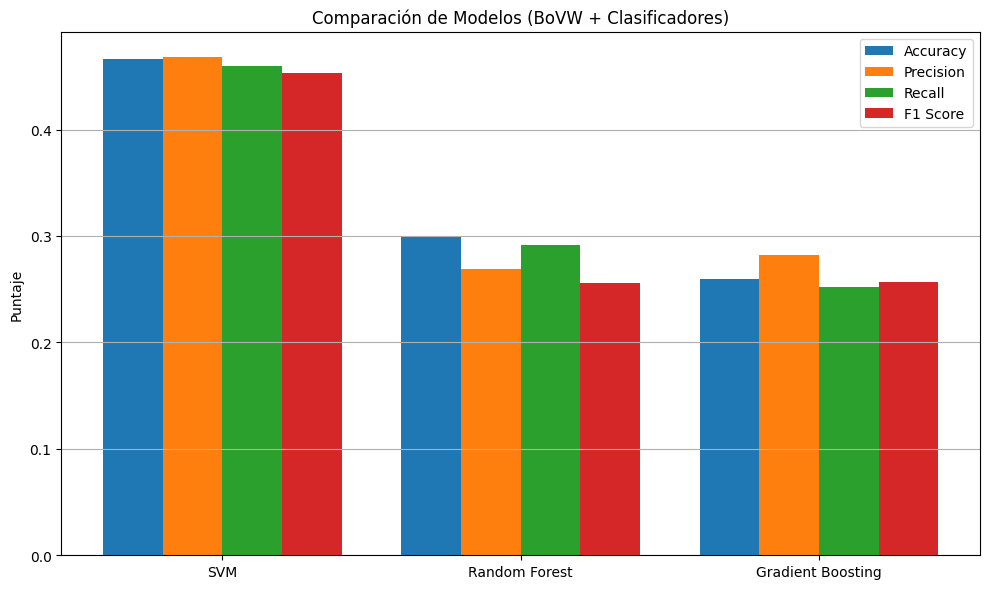

In [17]:



# Graficar
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metricas['Modelo']))
width = 0.2

ax.bar(x - 1.5*width, metricas['Accuracy'], width, label='Accuracy')
ax.bar(x - 0.5*width, metricas['Precision'], width, label='Precision')
ax.bar(x + 0.5*width, metricas['Recall'], width, label='Recall')
ax.bar(x + 1.5*width, metricas['F1 Score'], width, label='F1 Score')

ax.set_ylabel('Puntaje')
ax.set_title('Comparación de Modelos (BoVW + Clasificadores)')
ax.set_xticks(x)
ax.set_xticklabels(metricas['Modelo'])
ax.legend()
plt.tight_layout()
plt.grid(axis='y')

plt.show()

In [18]:
metricas

{'Modelo': ['SVM', 'Random Forest', 'Gradient Boosting'],
 'Accuracy': [0.4666666666666667, 0.3, 0.26],
 'Precision': [0.46836252149410035, 0.26891409354128654, 0.28230347413413776],
 'Recall': [0.4599735524193728, 0.2918691559558433, 0.2520134561001434],
 'F1 Score': [0.4531689801674735, 0.25595629920202684, 0.2572035991771608]}

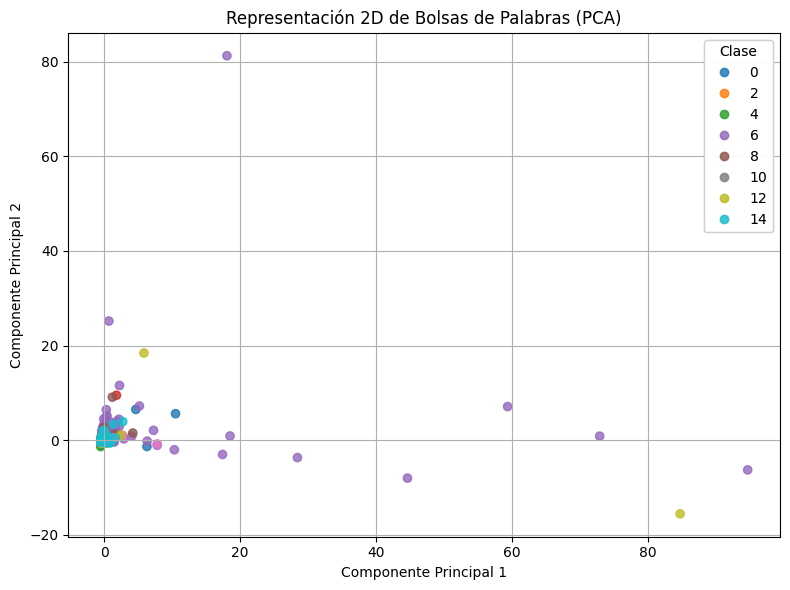

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)  # Usar las bolsas de palabras ya preparadas

# Crear gráfico en 2D
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10', alpha=0.8)

# Añadir leyenda por clase
legend = ax.legend(*scatter.legend_elements(), title="Clase")
ax.add_artist(legend)

ax.set_title("Representación 2D de Bolsas de Palabras (PCA)")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()

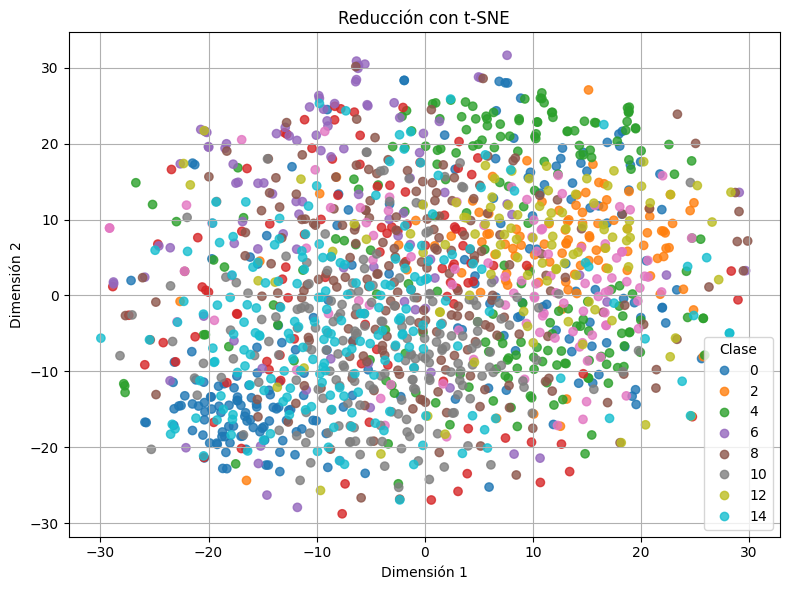

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10', alpha=0.8)
plt.legend(*scatter.legend_elements(), title="Clase")
plt.title("Reducción con t-SNE")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")
plt.grid(True)
plt.tight_layout()
plt.show()
